# Multi-cloudtype 
In this notebook, a model that will predict the mask for all four cloud types is looked at.  

In [1]:
import sys
sys.path.append('/Users/jack/git_repos/fastai_dev/dev')
from local.data.all import *
from local.vision.all import *
from local.vision.core import *
from local.vision.augment import *
from local.vision import models
from local.basics import *

## Data

In [2]:
CATS = ['fish', 'flower', 'gravel', 'sugar']

### Load the images' file paths and the annotations

In [3]:
SOURCE = Path('data/train_images/')

In [4]:
items = get_image_files(SOURCE)

In [5]:
IMG_SHAPE = PILImage.create(items[12]).shape

In [6]:
def load_train_annotation(fpath):
    df = pd.read_csv(fpath)
    df['Image'] = df.Image_Label.apply(lambda o: o.split('.')[0])
    df['Label'] = df.Image_Label.apply(lambda o: o.split('_')[1].lower())
    df.drop('Image_Label', axis=1, inplace=True)
    df = df[['Image', 'Label', 'EncodedPixels']]
    return df

In [7]:
annots = load_train_annotation('data/train.csv')

### Rescaling the images
The original size of the images is 2100 px in width and 1400 px in height.  To start off with something smaller, a `Transform` is created for rescaling the images.  Here, the aspect ratio is kept the same, so no cropping or squishing.

In [8]:
class RescaleTfm(TupleTransform):
    def __init__(self, max_w=210, resample=Image.BILINEAR): 
        self.max_w, self.resample = max_w, resample
        
    def encodes(self, o:PILImage): return o.resize_max(max_w=self.max_w, resample=self.resample)
    def encodes(self, o:PILMask): return o.resize_max(max_w=self.max_w, resample=Image.NEAREST)

In [9]:
SZ = 210

### Decode Run-length Encoding

In [10]:
def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    '''
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    
    Copied from https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

In [11]:
class RLE_Decode(Transform):
    def __init__(self, cat, annots, img_shape): 
        self.cat, self.annots, self.img_shape = cat,  annots, img_shape
        
    def encodes(self, o):
        df = self.annots[self.annots.Image == o.stem].fillna('')
        px_rle = df[df.Label == self.cat].EncodedPixels.values[0]
        return rle_decode(px_rle, IMG_SHAPE)

In [12]:
annots[annots.Image == items[16].stem]

,Image,Label,EncodedPixels
8600,61d6640,fish,NaN
8601,61d6640,flower,NaN
8602,61d6640,gravel,1349079 387 1350479 387 1351879 387 1353279 387 1354679 387 1356079 387 1357479 387 1358879 387 1360279 387 1361679 387 1363079 387 1364479 387 1365879 387 1367279 387 1368679 387 1370079 387 1371479 387 1372879 387 1374279 387 1375679 387 1377079 387 1378479 387 1379879 387 1381279 387 1382679 387 1384079 387 1385479 387 1386879 387 1388279 387 1389679 387 1391079 387 1392479 387 1393879 387 1395279 387 1396679 387 1398079 387 1399479 387 1400879 387 1402279 387 1403679 387 1405079 387 1406479 387 1407879 387 1409279 387 1410679 387 1412079 387 1413479 387 1414879 387 1416279 387 1417679 ...
8603,61d6640,sugar,373839 334 375239 334 376639 334 378039 334 379439 334 380839 334 382239 334 383639 334 385039 334 386439 334 387839 334 389239 334 390639 334 392039 334 393439 334 394839 334 396239 334 397639 334 399039 334 400439 334 401839 334 403239 334 404639 334 406039 334 407439 334 408839 334 410239 334 411639 334 413039 334 414439 334 415839 334 417239 334 418639 334 420039 334 421439 334 422839 334 424239 334 425639 334 427039 334 428439 334 429839 334 431239 334 432639 334 434039 334 435439 334 436839 334 438239 334 439639 334 441039 334 442439 334 443839 334 445239 334 446639 334 448039 334 44...


In [13]:
for cat in CATS: print(cat, RLE_Decode(cat, annots, IMG_SHAPE)(items[16]).sum())

fish 0
flower 0
gravel 326241
sugar 1264697


### DataSource

In [14]:
def to_pilmask(o): return PILMask.create(o)

In [15]:
class Tensor2MaskTfm(TupleTransform):
    def encodes(self, o): return PILMask.create(o)

In [16]:
split_idx = RandomSplitter()(items)
tensor2mask = Tensor2MaskTfm()

tfms = [[PILImage.create], 
        [RLE_Decode('fish', annots, IMG_SHAPE), tensor2mask],
        [RLE_Decode('flower', annots, IMG_SHAPE), tensor2mask],
        [RLE_Decode('gravel', annots, IMG_SHAPE), tensor2mask],
        [RLE_Decode('sugar', annots, IMG_SHAPE), tensor2mask]]

dsrc = DataSource(items, tfms=tfms, splits=split_idx, n_inp=1)

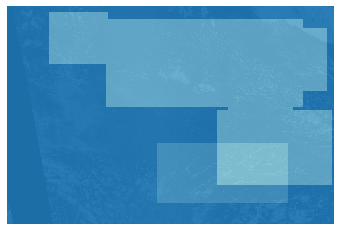

In [17]:
dsrc.show(dsrc[16]);

In [18]:
dsrc[16]

(<local.vision.core.PILImage image mode=RGB size=2100x1400 at 0x1113B4CD0>,
 <local.vision.core.PILMask image mode=L size=2100x1400 at 0x1113C3910>,
 <local.vision.core.PILMask image mode=L size=2100x1400 at 0x1113C3950>,
 <local.vision.core.PILMask image mode=L size=2100x1400 at 0x1113C3850>,
 <local.vision.core.PILMask image mode=L size=2100x1400 at 0x1113C3990>)

### DataBunch

In [19]:
rescale = RescaleTfm(max_w=SZ, resample=0)

In [20]:
rescale(dsrc[3])

(<local.vision.core.PILImage image mode=RGB size=210x140 at 0x1113C3110>,
 <local.vision.core.PILMask image mode=L size=210x140 at 0x1113C32D0>,
 <local.vision.core.PILMask image mode=L size=210x140 at 0x1113C3890>,
 <local.vision.core.PILMask image mode=L size=210x140 at 0x1113C3CD0>,
 <local.vision.core.PILMask image mode=L size=210x140 at 0x1113CD590>)

In [21]:
after_item_tfms = [rescale, ToTensor]

In [22]:
after_batch_tfms = [Cuda(), IntToFloatTensor()]

In [23]:
dbch = dsrc.databunch(after_item=after_item_tfms, after_batch=after_batch_tfms, bs=8)

In [24]:
xb, *yb = dbch.one_batch()

In [25]:
len(yb)

4

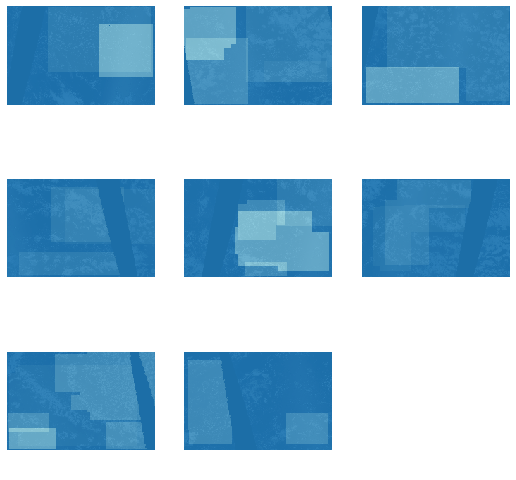

In [26]:
dbch.show_batch()

### Normalize

In [27]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [28]:
normalize = Normalize(*imagenet_stats)

Re-create `DataBunch`, adding `Normalize` transform:

In [29]:
after_item_tfms = [rescale, ToTensor]
after_batch_tfms = [Cuda(), IntToFloatTensor(), normalize]

In [30]:
dbch = dsrc.databunch(after_item=after_item_tfms, bs=4, after_batch=after_batch_tfms)

In [31]:
xb, *yb = dbch.one_batch()

In [32]:
xb.shape

torch.Size([4, 3, 140, 210])

In [33]:
for yb_ in yb: print(yb_.shape)

torch.Size([4, 140, 210])
torch.Size([4, 140, 210])
torch.Size([4, 140, 210])
torch.Size([4, 140, 210])


## Model


In [60]:
xb.shape, yb[0].shape, yb[1].shape, yb[2].shape

(torch.Size([4, 3, 140, 210]),
 torch.Size([4, 140, 210]),
 torch.Size([4, 140, 210]),
 torch.Size([4, 140, 210]))

In [61]:
encoder = models.resnet34(pretrained=True)
encoder = nn.Sequential(*list(encoder.children())[:-2])

In [62]:
model = models.unet.DynamicUnet(encoder=encoder, n_classes=2, img_size=xb.shape[-2:], norm_type=None)


In [63]:
pred = model(xb)

In [64]:
pred.shape

torch.Size([4, 2, 140, 210])

In [39]:
model[-1][0].in_channels, model[-1][0].out_channels, model[-1][0].kernel_size

(99, 2, (1, 1))

In [40]:
model[-1]

ConvLayer(
  (0): Conv2d(99, 2, kernel_size=(1, 1), stride=(1, 1))
)

In [41]:
ConvLayer(99, 2, ks=1, act_cls=None, norm_type=None)

ConvLayer(
  (0): Conv2d(99, 2, kernel_size=(1, 1), stride=(1, 1))
)

In [42]:
CATS

['fish', 'flower', 'gravel', 'sugar']

In [43]:
class CloudsCustomHead(nn.Module):
    def __init__(self):
        super().__init__()
        #self.conv_clouds = [ConvLayer(99, 2, ks=1, act_cls=None, norm_type=None) for _ in CATS]
        self.conv_fish = ConvLayer(99, 2, ks=1, act_cls=None, norm_type=None)
        self.conv_flower = ConvLayer(99, 2, ks=1, act_cls=None, norm_type=None)
        self.conv_gravel = ConvLayer(99, 2, ks=1, act_cls=None, norm_type=None)
        self.conv_sugar = ConvLayer(99, 2, ks=1, act_cls=None, norm_type=None)
                
    def forward(self, o):
        #return tuple(m(o) for m in self.conv_clouds)
        return self.conv_fish(o), self.conv_flower(o), self.conv_gravel(o), self.conv_sugar(o)

In [44]:
custom_head = CloudsCustomHead()
custom_head

CloudsCustomHead(
  (conv_fish): ConvLayer(
    (0): Conv2d(99, 2, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv_flower): ConvLayer(
    (0): Conv2d(99, 2, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv_gravel): ConvLayer(
    (0): Conv2d(99, 2, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv_sugar): ConvLayer(
    (0): Conv2d(99, 2, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [45]:
layers = list(model[:-1]) + [custom_head]

In [46]:
model = SequentialEx(*layers)

In [47]:
model

SequentialEx(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-0

In [48]:
y_test = model(xb)

In [49]:
y_test[0].shape, y_test[1].shape, y_test[2].shape, y_test[3].shape

(torch.Size([4, 2, 140, 210]),
 torch.Size([4, 2, 140, 210]),
 torch.Size([4, 2, 140, 210]),
 torch.Size([4, 2, 140, 210]))

In [50]:
yb[0].shape, yb[1].shape, yb[2].shape, yb[3].shape

(torch.Size([4, 140, 210]),
 torch.Size([4, 140, 210]),
 torch.Size([4, 140, 210]),
 torch.Size([4, 140, 210]))

## Loss Function

For the loss function the *cross entropy loss* is calculated for each of the four clouds types, and then they are summed.

In [51]:
y_test[0].shape, yb[0].shape

(torch.Size([4, 2, 140, 210]), torch.Size([4, 140, 210]))

In [52]:
CrossEntropyLossFlat(axis=1)(y_test[0], yb[0])

tensor(1.6068, grad_fn=<NllLossBackward>)

In [53]:
sum([nn.CrossEntropyLoss()(y_test[0], yb[0]), nn.CrossEntropyLoss()(y_test[1], yb[1])])

tensor(3.6356, grad_fn=<AddBackward0>)

In [54]:
class CloudsLoss(CrossEntropyLossFlat):
    def __init__(self, *args, axis=1, **kwargs): super().__init__(*args, axis=1, **kwargs)
    def __call__(self, inp, *targ, **kwargs):
        assert len(inp) == len(targ)
        f = super().__call__
        return sum([f(i, t, **kwargs) for i, t in zip(inp, targ)])

In [55]:
CloudsLoss()(y_test, *yb)

tensor(6.3529, grad_fn=<AddBackward0>)

## Metrics

For the metric, the fraction of correctly classified pixels is shown for each cloud type.

In [56]:
def acc_seg(inp, *targ): 
    assert len(inp) == len(targ)
    return torch.stack([(i.argmax(dim=1) == t).float().mean() for i, t in zip(inp, targ)]).mean()

In [57]:
acc_seg(y_test, *yb)

tensor(0.2279)

## Learner

In [58]:
learn = Learner(dbch, model, loss_func=CloudsLoss(), opt_func=SGD, metrics=acc_seg)

In [59]:
learn.fit(n_epoch=1)

(#3) [0,4.97456693649292,00:14]


RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

## Run-length encoding of masks

In [92]:
def mask2rle(img):
    '''
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

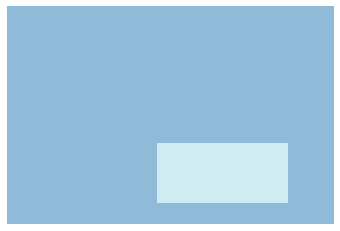

In [83]:
pilmask = dsrc[16][3]
pilmask.show()

In [87]:
mask_enc = mask2rle(tensor(pilmask))

In [85]:
type(mask_rle)

str

In [89]:
mask_dec = rle_decode(mask_enc, shape=pilmask.shape)

In [91]:
np.allclose(mask_dec, tensor(pilmask))

True

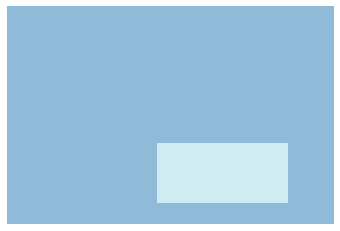

In [90]:
PILMask.create(mask_dec).show()

# - fin